# Hardware-Efficient Simulation of Energy Transfer Dynamics

Yuan Liu, 10/21/2022

In [1]:
# setup the matplotlib graphics library and configure it to show 
# figures inline in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi, sqrt
import pandas as pd

In [2]:
# make qutip available in the rest of the notebook
from qutip import *


## Hamiltonian
See the overleaf document for the exact Hamiltonian.

### Problem parameters


Here we use units where $\hbar = 1$, and I will use $cm^{-1}$ as frequency unit.

In [3]:
omega_ga = 4.95e13
omega_ea = 4.63e13
omega_gb = 4.98e13
omega_eb = 4.62e13
omega_gc = 4.92e13
omega_ec = 4.65e13
omega_l = 6.00e12
J_AB_0 = 3.00e12
J_AC_0 = 2.70e12
eta_AB = -0.1
eta_AC = 0.15
S_a = 0.005
S_b = 0.004
S_c = 0.006
S_l = 0.05 #tunable
gamma_A = 3.15e12
gamma_B = 3.15e12
gamma_C = 3.15e12


omega_a = (omega_ga + omega_ea)/2
omega_b = (omega_gb + omega_eb)/2
omega_c = (omega_gc + omega_ec)/2
omega_l = omega_l
chi_a = omega_ea - omega_ga
chi_b = omega_eb - omega_gb
chi_c = omega_ec - omega_gc
omega_qa = 2 * (S_a * omega_ea + S_l * omega_l) + (chi_a) / 2
omega_qb = 2 * S_b * omega_eb + (chi_b) / 2
omega_qc = 2 * S_c * omega_ec + (chi_c) / 2
g_cd_a = np.sqrt(2 * S_a) * omega_ea
g_cd_b = np.sqrt(2 * S_b) * omega_eb
g_cd_c = np.sqrt(2 * S_c) * omega_ec
g_cd_l = np.sqrt(2 * S_l) * omega_l
g_ab = J_AB_0
g_ac = J_AC_0
g_abl = g_ab * eta_AB
g_acl = g_ac * eta_AC
g_a = g_cd_a / 2
g_b = g_cd_b / 2
g_c = g_cd_c / 2
g_l = g_cd_l / 2
delta_ab = omega_qa - omega_qb
delta_ac = omega_qa - omega_qc


planck = 6.62607015e-34
planck = 1

gammaA = 3.15          # qubit A amplitude damping
gammaB = 3.15          # qubit B amplitude damping
gammaC = 3.15          # qubit C amplitude damping
kappa = 0.005       # cavity dissipation rate
n_th_a = 0.0        # avg number of thermal bath excitation

N = 2             # truncation level for the high frequency modes
#Nl = N           # truncation level for the low frequency mode
Nl = N*2           # truncation level for the low frequency mode

timelist = np.linspace(0,2e-12,200)

### Setup the operators, the Hamiltonian and initial state

In [4]:
# intial state, tensor product of three 2-level system and four bosonic modes.
# The last bosonic mode being the low frequency mode l. From left to right are A, B, C
psi0 = tensor(basis([2,2,2],[1,0,0]), basis([N,N,N,Nl],[0,0,0,0]))   
# start with an excited molecule A, and the rest in ground state

# identity operators
Id_qub = tensor(qeye(2), qeye(2), qeye(2))
Id_bos = tensor(qeye(N), qeye(N), qeye(N), qeye(Nl))

# projected bosonic mode operators
a_osc = tensor(destroy(N), qeye(N), qeye(N), qeye(Nl))
b_osc = tensor(qeye(N), destroy(N), qeye(N), qeye(Nl))
c_osc = tensor(qeye(N), qeye(N), destroy(N), qeye(Nl))
l_osc = tensor(qeye(N), qeye(N), qeye(N), destroy(Nl))
a  = tensor(Id_qub, a_osc)
b  = tensor(Id_qub, b_osc)
c  = tensor(Id_qub, c_osc)
l  = tensor(Id_qub, l_osc)

# qubit operators
smA = tensor(destroy(2), qeye(2), qeye(2))
smB = tensor(qeye(2), destroy(2), qeye(2))
smC = tensor(qeye(2), qeye(2), destroy(2))
sigma_xa_qub = tensor(sigmax(), qeye(2), qeye(2))
sigma_xb_qub = tensor(qeye(2), sigmax(), qeye(2))
sigma_xc_qub = tensor(qeye(2), qeye(2), sigmax())
sigma_ya_qub = tensor(sigmay(), qeye(2), qeye(2))
sigma_yb_qub = tensor(qeye(2), sigmay(), qeye(2))
sigma_yc_qub = tensor(qeye(2), qeye(2), sigmay())
sigma_za_qub = tensor(sigmaz(), qeye(2), qeye(2))
sigma_zb_qub = tensor(qeye(2), sigmaz(), qeye(2))
sigma_zc_qub = tensor(qeye(2), qeye(2), sigmaz())
sigma_xa = tensor(sigma_xa_qub, Id_bos)
sigma_xb = tensor(sigma_xb_qub, Id_bos)
sigma_xc = tensor(sigma_xc_qub, Id_bos)
sigma_ya = tensor(sigma_ya_qub, Id_bos)
sigma_yb = tensor(sigma_yb_qub, Id_bos)
sigma_yc = tensor(sigma_yc_qub, Id_bos)
sigma_za = tensor(sigma_za_qub, Id_bos)
sigma_zb = tensor(sigma_zb_qub, Id_bos)
sigma_zc = tensor(sigma_zc_qub, Id_bos)


# qubit states
GroundState = basis([2,2,2],[0,0,0])
eA = basis([2,2,2],[1,0,0])
eB = basis([2,2,2],[0,1,0])
eC = basis([2,2,2],[0,0,1])


# Bosonic Hamiltonians
H0 = (omega_a * a.dag() * a) + (omega_b * b.dag() * b) + (omega_c * c.dag() * c) + (omega_l * l.dag() * l) - (delta_ab * sigma_zb / 2) - (delta_ac * sigma_zc / 2)

H1 = -(chi_a * a.dag() * a * sigma_za / 2) - (chi_b * b.dag() * b * sigma_zb / 2) - (chi_c * c.dag() * c * sigma_zc / 2)
H1 = H1 - (g_cd_a * (a + a.dag()) * sigma_za / 2) - (g_cd_b * (b + b.dag()) * sigma_zb / 2) - (g_cd_c * (c + c.dag()) * sigma_zc / 2)

H2XX = -(g_cd_l * (l + l.dag()) * sigma_za / 4) + (g_ab * (sigma_xa * sigma_xb) / 2) + (g_ac * (sigma_xa * sigma_xc) / 2) 
H2XX = H2XX - (g_abl * (sigma_xa * sigma_xb) * (l + l.dag()) / 2) + (g_acl * (sigma_xa * sigma_xc) * (l + l.dag()) / 2)

H2YY = -(g_cd_l * (l + l.dag()) * sigma_za / 4) + (g_ab * (sigma_ya * sigma_yb) / 2) + (g_ac * (sigma_ya * sigma_yc) / 2) 
H2YY = H2YY - (g_abl * (sigma_ya * sigma_yb) * (l + l.dag()) / 2) + (g_acl * (sigma_ya * sigma_yc) * (l + l.dag()) / 2)


# Total Hamiltonian (without  dissipation)
Htot = (H0 + H1 + H2XX + H2YY) * planck

### Create a list of collapse operators that describe the dissipation

In [5]:
'''c_ops = []

# qubit relaxation, to model the last term in the chromophore Hamiltonian
rate = gammaA
if rate > 0.0:
    c_ops.append(tensor(sqrt(rate) * smA, Id_bos))

    
rate = gammaB
if rate > 0.0:
    c_ops.append(tensor(sqrt(rate) * smB, Id_bos))

rate = gammaC
if rate > 0.0:
    c_ops.append(tensor(sqrt(rate) * smC, Id_bos))


# Additional Cavity dissipation terms
# mode a relaxation
rate = kappa * (1 + n_th_a)
if rate > 0.0:
    c_ops.append(tensor(Id_qub, sqrt(rate) * a))
# mode a excitation, if temperature > 0
rate = kappa * n_th_a
if rate > 0.0:
    c_ops.append(tensor(Id_qub, sqrt(rate) * a.dag()))
    
# mode b relaxation
rate = kappa * (1 + n_th_a)
if rate > 0.0:
    c_ops.append(tensor(Id_qub, sqrt(rate) * b))
# mode b excitation, if temperature > 0
rate = kappa * n_th_a
if rate > 0.0:
    c_ops.append(tensor(Id_qub, sqrt(rate) * b.dag()))


# mode c relaxation
rate = kappa * (1 + n_th_a)
if rate > 0.0:
    c_ops.append(tensor(Id_qub, sqrt(rate) * c))
# mode c excitation, if temperature > 0
rate = kappa * n_th_a
if rate > 0.0:
    c_ops.append(tensor(Id_qub, sqrt(rate) * c.dag()))

    
# mode l relaxation
rate = kappa * (1 + n_th_a)
if rate > 0.0:
    c_ops.append(tensor(Id_qub, sqrt(rate) * l))
# mode l excitation, if temperature > 0
rate = kappa * n_th_a
if rate > 0.0:
    c_ops.append(tensor(Id_qub, sqrt(rate) * l.dag()))

'''

'c_ops = []\n\n# qubit relaxation, to model the last term in the chromophore Hamiltonian\nrate = gammaA\nif rate > 0.0:\n    c_ops.append(tensor(sqrt(rate) * smA, Id_bos))\n\n    \nrate = gammaB\nif rate > 0.0:\n    c_ops.append(tensor(sqrt(rate) * smB, Id_bos))\n\nrate = gammaC\nif rate > 0.0:\n    c_ops.append(tensor(sqrt(rate) * smC, Id_bos))\n\n\n# Additional Cavity dissipation terms\n# mode a relaxation\nrate = kappa * (1 + n_th_a)\nif rate > 0.0:\n    c_ops.append(tensor(Id_qub, sqrt(rate) * a))\n# mode a excitation, if temperature > 0\nrate = kappa * n_th_a\nif rate > 0.0:\n    c_ops.append(tensor(Id_qub, sqrt(rate) * a.dag()))\n    \n# mode b relaxation\nrate = kappa * (1 + n_th_a)\nif rate > 0.0:\n    c_ops.append(tensor(Id_qub, sqrt(rate) * b))\n# mode b excitation, if temperature > 0\nrate = kappa * n_th_a\nif rate > 0.0:\n    c_ops.append(tensor(Id_qub, sqrt(rate) * b.dag()))\n\n\n# mode c relaxation\nrate = kappa * (1 + n_th_a)\nif rate > 0.0:\n    c_ops.append(tensor(Id_q

### Evolve the system

Here we evolve the system with the Lindblad master equation solver or the Monte Carlo solver, and we request that the expectation values of the operators $a^\dagger a$ and $\sigma_{+,A}\sigma_{-,A}$ are returned by the solver.

In [6]:
# Monte Carlo Solver
#ntraj = [1, 5, 15, 904] # list of number of trajectories to avg. over
#ntraj = [1] # list of number of trajectories to avg. over
#output = mcsolve(Htot, psi0, tlist, c_ops, [tensor(Id_qub, a.dag() * a), tensor(smA.dag() * smA, Id_bos)], ntraj)

# Lindblad Master Equation Solver
c_ops = []
output = mesolve(Htot, psi0, timelist, c_ops, [tensor(Id_qub, a_osc.dag() * a_osc), tensor(Id_qub, b_osc.dag() * b_osc), 
                                         tensor(Id_qub, c_osc.dag() * c_osc), tensor(Id_qub, l_osc.dag() * l_osc), 
                                         tensor(smA.dag() * smA, Id_bos), 
                                         tensor(smB.dag() * smB, Id_bos), 
                                         tensor(smC.dag() * smC, Id_bos)],
                 options=Options(nsteps=30000))

C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


## Visualize the results

Here we plot the excitation probabilities of the mode and the qubit (these expectation values were calculated by the `mesolve` above).

FileNotFoundError: [Errno 2] No such file or directory: 'data/final/10000shots_updated/nodamping.out'

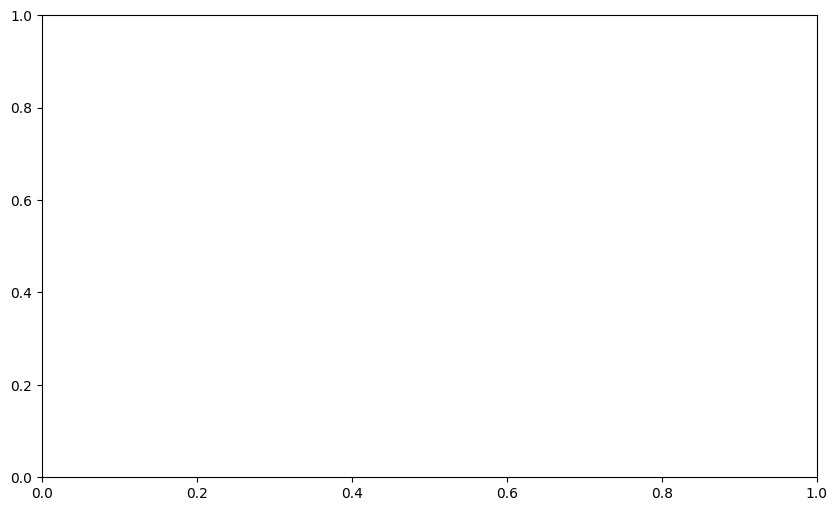

In [7]:
n_a = output.expect[0]
n_b = output.expect[1]
n_c = output.expect[2]
n_l = output.expect[3]
n_A = output.expect[4]
n_B = output.expect[5]
n_C = output.expect[6]

fig, axes = plt.subplots(1, 1, figsize=(10,6))

data_file = 'data/final/10000shots_updated/nodamping.out'
df = pd.read_csv(data_file, delimiter='\s*\(|[\+-]\d\.\d+e[\+-]\d+j\) *\(|[\+-]\d\.\d+e[\+-]\d+j\)', engine = 'python')
df.drop(columns=df.columns[0], axis=1, inplace=True)
df.drop(columns=df.columns[len(df.columns)-1], axis=1, inplace=True)
df.columns = df.columns.map(float)
data = df.to_numpy()
columns = df.columns.to_numpy()
columns = columns / 1e12
axes.plot(columns, data[0], '--', label="Simulated Chromophore A", color='#0085ec')
axes.plot(columns, data[1], '--', label="Simulated Chromophore B", color='#fa8f00')
axes.plot(columns, data[2], '--', label="Simulated Chromophore C", color='#008a02')


#axes.plot(tlist, n_a, '--', label="Mode a")
#axes.plot(tlist, n_b, '--', label="Mode b")
#axes.plot(tlist, n_c, '--', label="Mode c")
#axes.plot(tlist, n_l, '--', label="Mode l")

axes.plot(timelist, n_A, label="Exact Chromophore A", color='#0065b4')
axes.plot(timelist, n_B, label="Exact Chromophore B", color='#d07700')
axes.plot(timelist, n_C, label="Exact Chromophore C", color='#006802')
axes.legend(loc=0)
axes.set_xlabel('Time (s)')
axes.set_ylabel('Concentration')
axes.set_title('Population Dynamics in the Excited State')
#plt.grid()
plt.savefig('exact\ runs/test.png', dpi=300)

In [64]:
from qutip.ipynbtools import version_table

version_table()